# Introduction to Recommendation systems

In this modern world we are overloaded with data and this data provides us the useful information. But it's not possible for the user to extract the information which interest them from these data. In order to help the user to find out information about the product , recommedation systems where developed. 

Recommeder system creates a similarity between the user and items and exploits the similarity between user/item to make recommendation


# 1. Import the libraries 

In [1]:
!pip install scikit-surprise

In [2]:
#import the reqired libraries
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import time
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import joblib 
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')

#Importing Surprise and relevant packages to do some hyper parameter tuning through Grid Search
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV
from surprise import KNNBasic, KNNWithMeans, KNNWithZScore
from surprise import SVD, SVDpp, NMF
from surprise import SlopeOne, CoClustering
# %matplotlib inline

# 2. Load the dataset and add headers

In [3]:
# Import the dataset and give the column names
columns=['userId', 'productId', 'ratings','timestamp']
df=pd.read_csv('ratings_Electronics.csv',names=columns)

In [4]:
df.head()

,userId,productId,ratings,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [5]:
df.describe()

,ratings,timestamp
count,7.824482e+06,7.824482e+06
mean,4.012337e+00,1.338178e+09
std,1.380910e+00,6.900426e+07
min,1.000000e+00,9.127296e+08
25%,3.000000e+00,1.315354e+09
50%,5.000000e+00,1.361059e+09
75%,5.000000e+00,1.386115e+09
max,5.000000e+00,1.406074e+09


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     object 
 1   productId  object 
 2   ratings    float64
 3   timestamp  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 238.8+ MB


In [7]:
print('Number of missing values across columns: \n',df.isnull().sum())


Number of missing values across columns: 
 userId       0
productId    0
ratings      0
timestamp    0
dtype: int64


<Axes: >

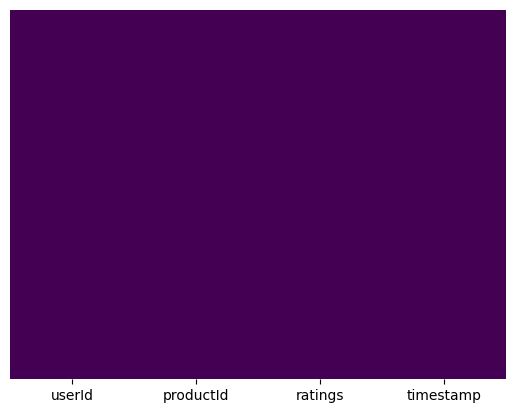

In [8]:
sns.heatmap(df.isna(), yticklabels=False, cbar=False, cmap='viridis')

In [9]:
df.isna().any()

userId       False
productId    False
ratings      False
timestamp    False
dtype: bool

In [10]:
df_transpose = df.describe().T
df_transpose

,count,mean,std,min,25%,50%,75%,max
ratings,7824482.0,4.012337e+00,1.380910e+00,1.0,3.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00
timestamp,7824482.0,1.338178e+09,6.900426e+07,912729600.0,1.315354e+09,1.361059e+09,1.386115e+09,1.406074e+09


In [11]:
df_transpose[['min', '25%', '50%', '75%', 'max']]

,min,25%,50%,75%,max
ratings,1.0,3.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00
timestamp,912729600.0,1.315354e+09,1.361059e+09,1.386115e+09,1.406074e+09


array([[<Axes: title={'center': 'ratings'}>]], dtype=object)

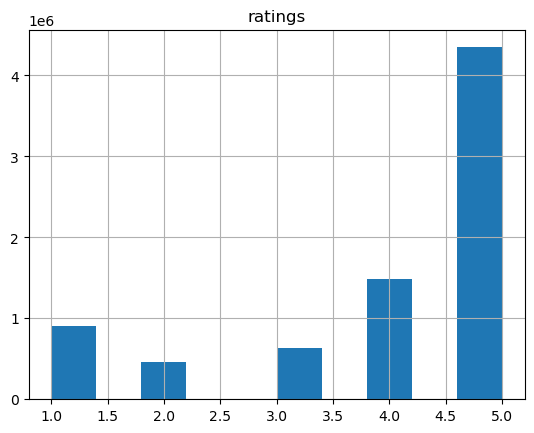

In [12]:
df.hist('ratings',bins = 10)

<Figure size 2000x500 with 0 Axes>

<Axes: >

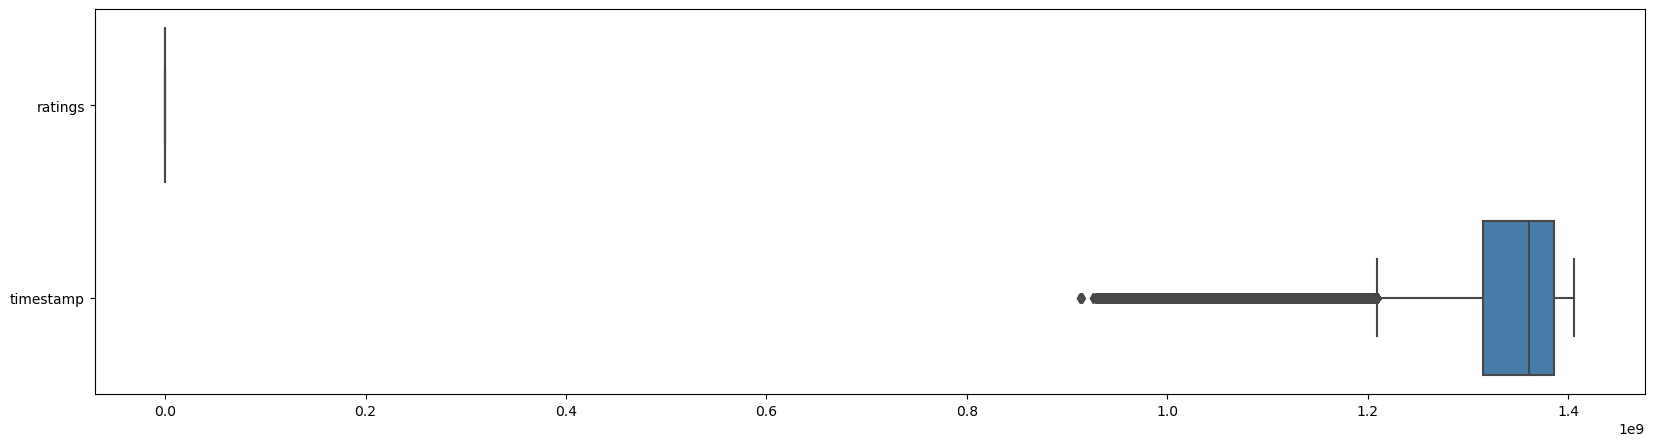

In [13]:
# Checking the presence of outliers :-¶
plt.figure(figsize=(20,5))
sns.boxplot(data=df, orient='h', palette='Set1', dodge=False)

Done in 116.772s


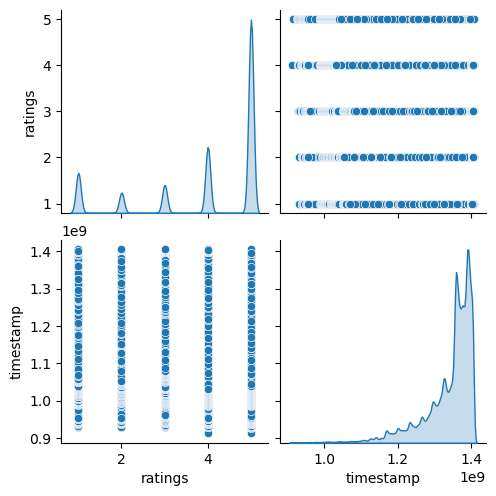

In [14]:
# Pair plot that includes all the columns of the data frame :-¶
start_time = time.time()

sns.pairplot(df, diag_kind= 'kde')

compute_time = time.time() - start_time
print('Done in %0.3fs' %(compute_time))

In [15]:
counts_rating = pd.DataFrame(df['ratings'].value_counts()).reset_index()
counts_rating.columns = ['Labels', 'Ratings']
counts_rating

,Labels,Ratings
0,5.0,4347541
1,4.0,1485781
2,1.0,901765
3,3.0,633073
4,2.0,456322


<Axes: ylabel='count'>

Text(0.5, 0, 'Rating Distribution')

Text(0, 0.5, 'Count')

([<matplotlib.patches.Wedge at 0x7f26fb7d84c0>,
 [Text(-1.1818200112387063, 0.20809003108208818, '5.0'),
  Text(0.6184167717030797, -0.9097036311218841, '4.0'),
  Text(1.1998625200851094, -0.01816405502663795, '1.0'),
  Text(0.9071776025006694, 0.6221163858323762, '3.0'),
  Text(0.5582519010301977, 0.9478158128012902, '2.0')],
 [Text(-0.689395006555912, 0.12138585146455143, '55.56%'),
  Text(0.3373182391107707, -0.49620198061193677, '18.99%'),
  Text(0.6999198033829803, -0.010595698765538805, '11.52%'),
  Text(0.49482414681854686, 0.3393362104540233, '8.09%'),
  Text(0.30450103692556235, 0.5169904433461583, '5.83%')])

(-1.2084078918383336,
 1.2099121819287646,
 -1.1008669061871383,
 1.118207639062974)

Text(0.5, 1.0, 'Rating Ratio')

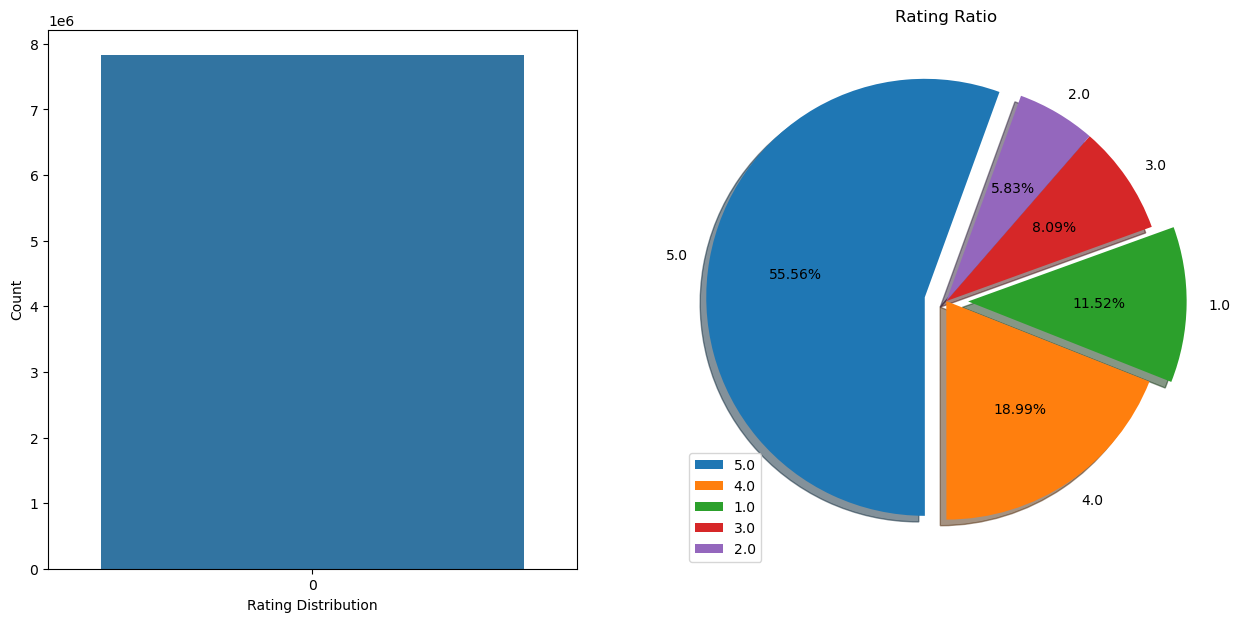

In [16]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,7))
sns.countplot(df['ratings'], ax=ax1)
ax1.set_xlabel('Rating Distribution', fontsize=10)
ax1.set_ylabel('Count', fontsize=10)


explode = (0.1, 0, 0.1, 0, 0)
ax2.pie(counts_rating["Ratings"], explode=explode, labels=counts_rating.Labels, autopct='%1.2f%%',
        shadow=True, startangle=70)
ax2.axis('equal')
plt.title("Rating Ratio")
plt.legend(counts_rating.Labels, loc=3)
plt.show()

In [17]:
#Using mean of products rating :-¶
df.groupby('productId')['ratings'].mean().head()

productId
0132793040    5.000000
0321732944    5.000000
0439886341    1.666667
0511189877    4.500000
0528881469    2.851852
Name: ratings, dtype: float64

* There are no missing records in the dataset.

In [18]:
#Check the number of rows and columns
rows,columns=df.shape
print('Number of rows: ',rows)
print('Number of columns: ',columns)

Number of rows:  7824482
Number of columns:  4


<BarContainer object of 20 artists>

([<matplotlib.axis.XTick at 0x7f26fb7da770>,
 [Text(0, 0, 'A3OXHLG6DIBRW8'),
  Text(1, 0, 'ADLVFFE4VBT8'),
  Text(2, 0, 'A5JLAU2ARJ0BO'),
  Text(3, 0, 'A6FIAB28IS79'),
  Text(4, 0, 'A680RUE1FDO8B'),
  Text(5, 0, 'A1ODOGXEYECQQ8'),
  Text(6, 0, 'A36K2N527TXXJN'),
  Text(7, 0, 'A2AY4YUOX2N1BQ'),
  Text(8, 0, 'A25C2M3QF9G7OQ'),
  Text(9, 0, 'AWPODHOB4GFWL'),
  Text(10, 0, 'A2NOW4U7W3F7RI'),
  Text(11, 0, 'ARBKYIVNYWK3C'),
  Text(12, 0, 'A3EXWV8FNSSFL6'),
  Text(13, 0, 'A22CW0ZHY3NJH8'),
  Text(14, 0, 'A38RMU1Y5TDP9'),
  Text(15, 0, 'A23GFTVIETX7DS'),
  Text(16, 0, 'A3LGT6UZL99IW1'),
  Text(17, 0, 'A2XRMQA6PJ5ZJ8'),
  Text(18, 0, 'A3PD8JD9L4WEII'),
  Text(19, 0, 'A2NYK9KWFMJV4Y')])

Text(0, 0.5, 'useId')

Text(0.5, 1.0, 'Most popular')

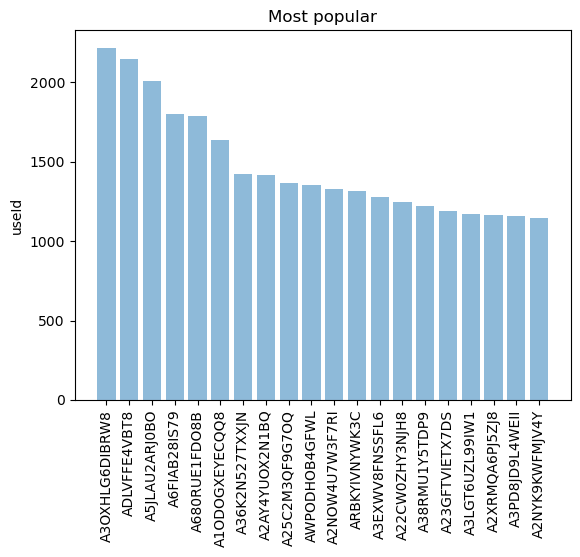

In [19]:
popular = df[['userId','ratings']].groupby('userId').sum().reset_index()
popular_20 = popular.sort_values('ratings', ascending=False).head(n=20)
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
 
objects = (list(popular_20['userId']))
y_pos = np.arange(len(objects))
performance = list(popular_20['ratings'])
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects, rotation='vertical')
plt.ylabel('useId')
plt.title('Most popular')
 
plt.show()

In [20]:
# find unique users
df.userId.value_counts()

A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
                 ... 
A1IUWX30VMVJGP      1
A1WBP7XSZI6AUL      1
A2K7UNJHE9ZR0G      1
A1A6SIW6EWF6FP      1
A10M2KEFPEQDHN      1
Name: userId, Length: 4201696, dtype: int64

In [21]:
print('Number of unique products', len(df['productId'].unique()))

print('Unique Ratings', df['ratings'].unique())

min_ratings1 = df[(df['ratings'] < 2.0)]
print('Number of unique products rated low',len(min_ratings1['productId'].unique()))

med_ratings1 = df[(df['ratings'] > 2.0) & (df['ratings'] < 4.0)]
print('Number of unique products rated medium',len(med_ratings1['productId'].unique()))
max_ratings1 = df[df['ratings'] >= 4.0]
print('Number of unique products rated high',len(max_ratings1['productId'].unique()))


Number of unique products 476002
Unique Ratings [5. 1. 3. 2. 4.]
Number of unique products rated low 176283
Number of unique products rated medium 152827
Number of unique products rated high 410110


In [22]:
userID = df.groupby('userId').count()
top_user = userID[userID['ratings'] >= 50].index
topuser_ratings_df = df[df['userId'].isin(top_user)]
#topuser_ratings_df.drop('productID', axis=1, inplace = True)
topuser_ratings_df.shape
topuser_ratings_df.head()

(125871, 4)

,userId,productId,ratings,timestamp
94,A3BY5KCNQZXV5U,0594451647,5.0,1390176000
118,AT09WGFUM934H,0594481813,3.0,1377907200
177,A32HSNCNPRUMTR,0970407998,1.0,1319673600
178,A17HMM1M7T9PJ1,0970407998,4.0,1281744000
492,A3CLWR1UUZT6TG,0972683275,5.0,1373587200


In [23]:
topuser_ratings_df.sort_values(by='ratings', ascending=False).head()

,userId,productId,ratings,timestamp
94,A3BY5KCNQZXV5U,0594451647,5.0,1390176000
4256669,A680RUE1FDO8B,B004M8RWDE,5.0,1356825600
4258497,AOMEH9W6LHC4S,B004M8SBNE,5.0,1324857600
4258199,A2GKMXRLI7KLFP,B004M8SBD4,5.0,1322438400
4258099,A1UNJ46NSB352E,B004M8SBCK,5.0,1319760000


## 3. Exploratory Data Analysis

array([[<Axes: title={'center': 'ratings'}>,
        <Axes: title={'center': 'timestamp'}>]], dtype=object)

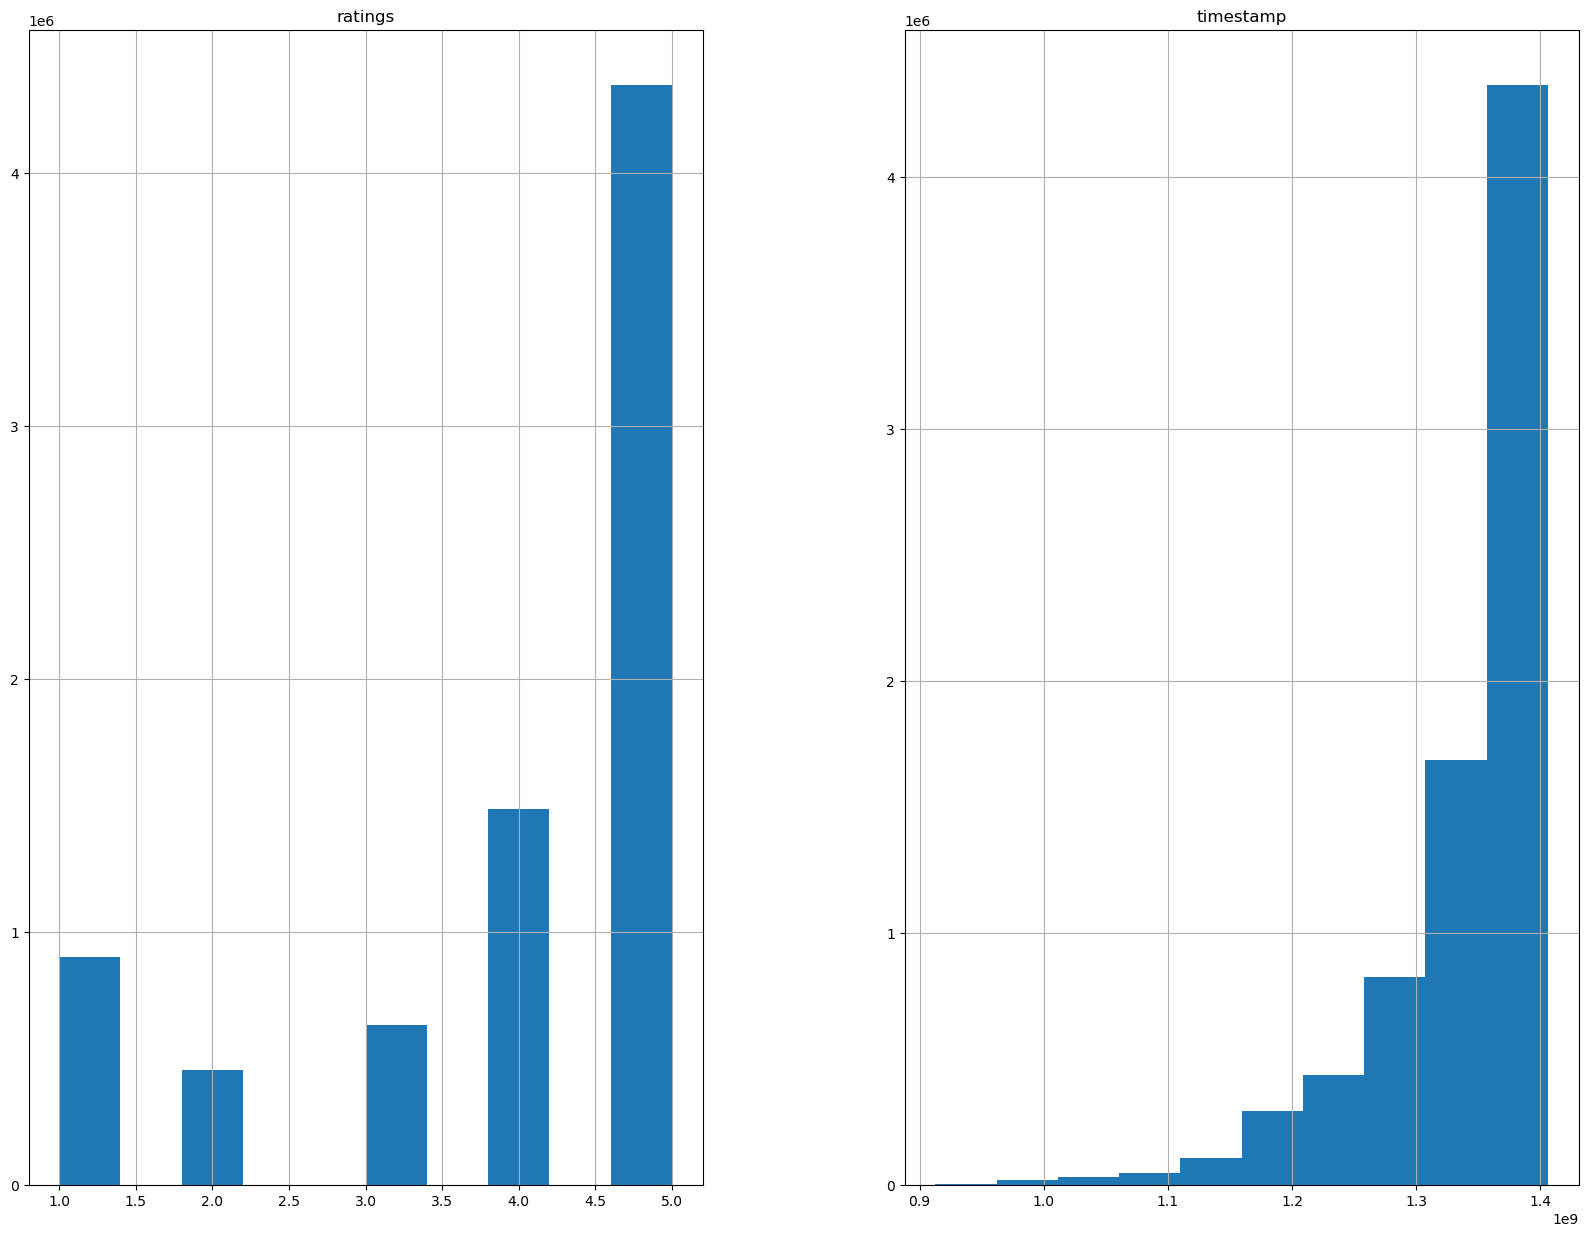

In [24]:
df.hist(figsize=(20, 15))
plt.show()

In [25]:
df.drop('timestamp',axis=1,inplace=True)

In [26]:
#Number of products is less than number of users, so item-item colaborative filtering would make sense
#instead of user-user colaborative filtering
print("Electronic Data Summary")
print("="*100)
print("\nTotal # of Ratings :",len(np.unique(df.ratings)))
print("Total # of Users   :", len(np.unique(df.userId)))
print("Total # of Products  :", len(np.unique(df.productId)))
print("\n")
print("="*100)

Electronic Data Summary

Total # of Ratings : 5
Total # of Users   : 4201696
Total # of Products  : 476002




* Since the data is very big. Consider electronics_df1 named dataframe with  first 50000 rows and all columns from 0 of dataset.

In [27]:
#Taking subset of the dataset
df1=df.iloc[:10000,0:]

In [28]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   userId     10000 non-null  object 
 1   productId  10000 non-null  object 
 2   ratings    10000 non-null  float64
dtypes: float64(1), object(2)
memory usage: 234.5+ KB


In [29]:
#Summary statistics of rating variable
df1['ratings'].describe().transpose()

count    10000.000000
mean         3.920000
std          1.467384
min          1.000000
25%          3.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: ratings, dtype: float64

In [30]:
#Find the minimum and maximum ratings
print('Minimum rating is: %d' %(df1.ratings.min()))
print('Maximum rating is: %d' %(df1.ratings.max()))

Minimum rating is: 1
Maximum rating is: 5


* Rating are on the scale 1 to 5.

### Ratings Analysis

In [31]:
df

,userId,productId,ratings
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0
...,...,...,...
7824477,A2YZI3C9MOHC0L,BT008UKTMW,5.0
7824478,A322MDK0M89RHN,BT008UKTMW,5.0
7824479,A1MH90R0ADMIK0,BT008UKTMW,4.0
7824480,A10M2KEFPEQDHN,BT008UKTMW,4.0


In [32]:
# Keep data only for products that have 50 or more ratings
prodID = df.groupby('productId').count()
top_prod = prodID[prodID['ratings'] >= 50].index
top_ratings_df = topuser_ratings_df[topuser_ratings_df['productId'].isin(top_prod)]
top_ratings_df.sort_values(by='ratings', ascending=False).head() 

,userId,productId,ratings,timestamp
492,A3CLWR1UUZT6TG,0972683275,5.0,1373587200
4220481,A2AY4YUOX2N1BQ,B004KJE8FU,5.0,1331683200
4217715,A2Q204DY2L7YRP,B004K8WPUQ,5.0,1354060800
4218748,A87CILADRIZW0,B004KA8Y4U,5.0,1393459200
4219205,A11KZ906QD08C5,B004KCI80I,5.0,1328054400


<Axes: ylabel='ratings'>

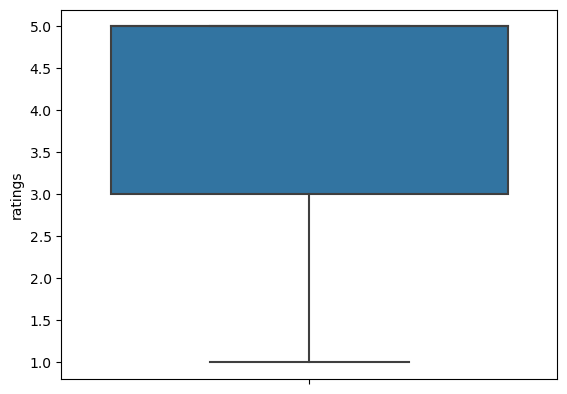

In [33]:
sns.boxplot(y='ratings',data = df)

* We can see that more number of users have given the rating between 3 to 5

In [34]:
#Check the top 10 users based on ratings
df1 = df.copy()
df1.drop_duplicates(inplace=True)
most_rated=df1.groupby('userId').size().sort_values(ascending=False)
print('Top 10 users based on ratings: \n',most_rated[:10])

Top 10 users based on ratings: 
 userId
A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
A1ODOGXEYECQQ8    380
A36K2N527TXXJN    314
A2AY4YUOX2N1BQ    311
AWPODHOB4GFWL     308
A25C2M3QF9G7OQ    296
dtype: int64


In [35]:
most_rated.describe().astype(int).T

count    4201696
mean           1
std            2
min            1
25%            1
50%            1
75%            2
max          520
dtype: int64

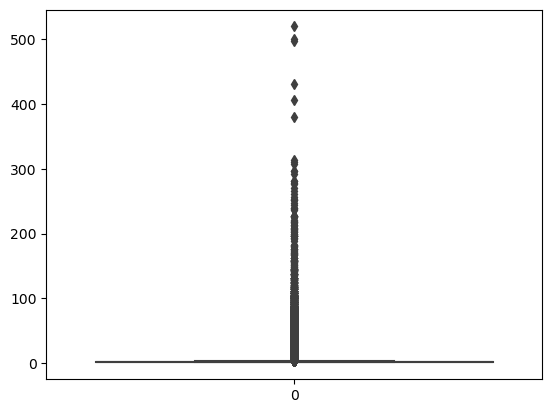

In [36]:
#Boxplot shows that we have few users who rate many items (appearing in outliers) but majority rate very few items

sns.boxplot(data=most_rated);

In [37]:
#Let us look at the quantile view to understand where the ratings are concentrated
quantiles = most_rated.quantile(np.arange(0,1.01,0.01), interpolation='higher')

<Figure size 1000x1000 with 0 Axes>

Text(0.5, 1.0, 'Quantiles and their Values')

<Axes: title={'center': 'Quantiles and their Values'}>

Text(0, 0.5, '# ratings by user')

Text(0.5, 0, 'Value at the quantile')

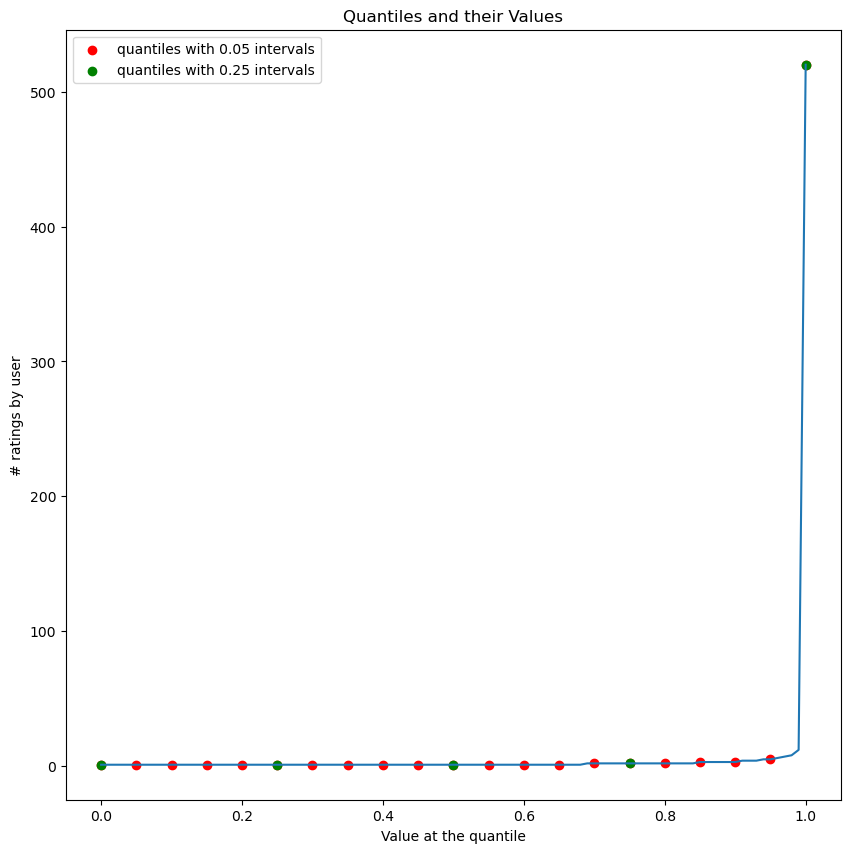

In [38]:
#We can see that all the ratings are clustered at the top end of the quantile
#Basically the outliers that we saw earlier are reflected here in the peak
plt.figure(figsize=(10,10))
plt.title("Quantiles and their Values")
quantiles.plot()
# quantiles with 0.05 difference
plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='red', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='green', label = "quantiles with 0.25 intervals")
plt.ylabel('# ratings by user')
plt.xlabel('Value at the quantile')
plt.legend(loc='best')
plt.show()

In [39]:
counts=df1.userId.value_counts()
df1_final=df1[df1.userId.isin(counts[counts>=10].index)]
print('Number of users who have rated 10 or more items =', len(df1_final))
print('Number of unique users in the final data = ', df1_final['userId'].nunique())
print('Number of unique products in the final data = ', df1_final['userId'].nunique())

Number of users who have rated 10 or more items = 1089763
Number of unique users in the final data =  63175
Number of unique products in the final data =  63175


* electronics_df1_final has the users who have rated 10 or more items.

In [40]:
# Taking Subset of users who have given 50 or more number of ratings :-
users_counts = df1['userId'].value_counts().rename('users_counts')
users_data   = df1.merge(users_counts.to_frame(),left_on='userId',
                                right_index=True)
subset_df = users_data[users_data.users_counts >= 50]
subset_df.head()

,userId,productId,ratings,users_counts
94,A3BY5KCNQZXV5U,0594451647,5.0,50
14863,A3BY5KCNQZXV5U,B00000JD4V,4.0,50
134213,A3BY5KCNQZXV5U,B000063574,5.0,50
338368,A3BY5KCNQZXV5U,B0000CDJP8,5.0,50
634048,A3BY5KCNQZXV5U,B0007Y794O,5.0,50


In [41]:
#Taking Subset of users who have given 50 or more number of ratings :-¶
users_counts = df1['userId'].value_counts().rename('users_counts')
users_data   = df1.merge(users_counts.to_frame(),left_on='userId',right_index=True)

In [41]:
# Taking Subset of products which have recieved 10 or more number of ratings to overcome the Grey Ship problem :-¶
product_rating_counts = subset_df['productId'].value_counts().rename('product_rating_counts')
product_rating_data   = subset_df.merge(product_rating_counts.to_frame(),
                                left_on='productId',
                                right_index=True)

In [42]:
product_rating_data = product_rating_data[product_rating_data.product_rating_counts >= 10]
product_rating_data.head()

,userId,productId,ratings,users_counts,product_rating_counts
634048,A3BY5KCNQZXV5U,B0007Y794O,5.0,50,18
633970,AKT8TGIT6VVZ5,B0007Y794O,5.0,192,18
633944,A1ILWPH1GHUXE2,B0007Y794O,4.0,98,18
634073,A1ZM846Y7AUYD,B0007Y794O,4.0,77,18
633998,A2ED50E3KWKUKW,B0007Y794O,5.0,65,18


In [43]:
amazon_df = product_rating_data.copy()
panda_data = amazon_df.drop(['users_counts', 'product_rating_counts'], axis=1)
panda_data.head()

,userId,productId,ratings
634048,A3BY5KCNQZXV5U,B0007Y794O,5.0
633970,AKT8TGIT6VVZ5,B0007Y794O,5.0
633944,A1ILWPH1GHUXE2,B0007Y794O,4.0
634073,A1ZM846Y7AUYD,B0007Y794O,4.0
633998,A2ED50E3KWKUKW,B0007Y794O,5.0


In [44]:
#Count of user_id for each unique as recommendation score 
panda_data_grouped = df.groupby('productId').agg({'userId': 'count'}).reset_index()
panda_data_grouped.rename(columns = {'userId': 'score'},inplace=True)
panda_data_grouped.head()

,productId,score
0,0132793040,1
1,0321732944,1
2,0439886341,3
3,0511189877,6
4,0528881469,27


In [45]:
#Sort the songs on recommendation score 
panda_data_sort = panda_data_grouped.sort_values(['score', 'productId'], ascending = [0,1]) 
      
#Generate a recommendation rank based upon score 
panda_data_sort['Rank'] = panda_data_sort['score'].rank(ascending=0, method='first') 
          
#Get the top 50 recommendations 
k = 50
popularity_recommendations = panda_data_sort.head(k) 
popularity_recommendations 

,productId,score,Rank
308398,B0074BW614,18244,1.0
429572,B00DR0PDNE,16454,2.0
327308,B007WTAJTO,14172,3.0
102804,B0019EHU8G,12285,4.0
296625,B006GWO5WK,12226,5.0
178601,B003ELYQGG,11617,6.0
178813,B003ES5ZUU,10276,7.0
323013,B007R5YDYA,9907,8.0
289775,B00622AG6S,9823,9.0
30276,B0002L5R78,9487,10.0


Text(0.5, 1.0, '# RATINGS per Product')

Text(0.5, 0, 'Product')

Text(0, 0.5, '# ratings per product')

[Text(-25000.0, 0, ''),
 Text(0.0, 0, ''),
 Text(25000.0, 0, ''),
 Text(50000.0, 0, ''),
 Text(75000.0, 0, ''),
 Text(100000.0, 0, ''),
 Text(125000.0, 0, ''),
 Text(150000.0, 0, ''),
 Text(175000.0, 0, ''),
 Text(200000.0, 0, ''),
 Text(225000.0, 0, '')]

<function matplotlib.pyplot.show(close=None, block=None)>

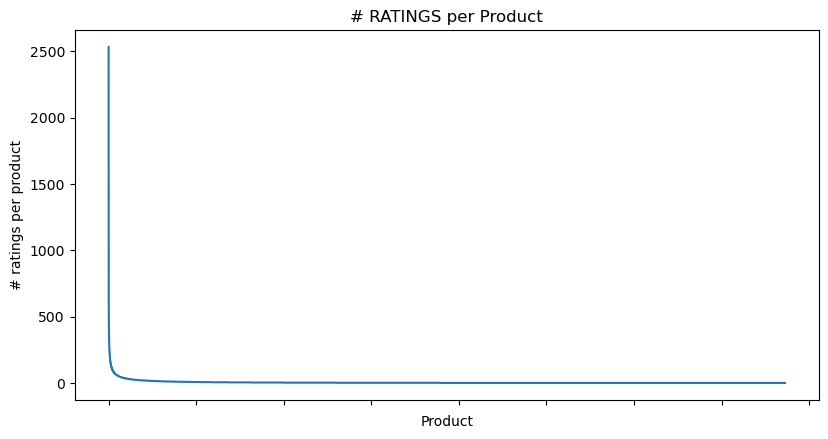

In [46]:
#Products also have skewed ratings with majority of the products having very few ratings
no_of_ratings_per_product = df1_final.groupby(by='productId')['ratings'].count().sort_values(ascending=False)

fig = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()
plt.plot(no_of_ratings_per_product.values)
plt.title('# RATINGS per Product')
plt.xlabel('Product')
plt.ylabel('# ratings per product')
ax.set_xticklabels([])

plt.show

In [47]:
ratings_mean_count = pd.DataFrame(df1_final.groupby('productId')['ratings'].mean())
ratings_mean_count['rating_counts'] = pd.DataFrame(df1_final.groupby('productId')['ratings'].count())
ratings_mean_count.head()




,ratings,rating_counts
productId,,
0511189877,2.000000,1
0528881469,2.500000,2
0594033926,5.000000,1
0594451647,5.000000,2
0594481813,3.833333,6


In [48]:
#The maximum number of ratings received for a product is 242

ratings_mean_count['rating_counts'].max()

2534

<Figure size 800x600 with 0 Axes>

<Axes: >

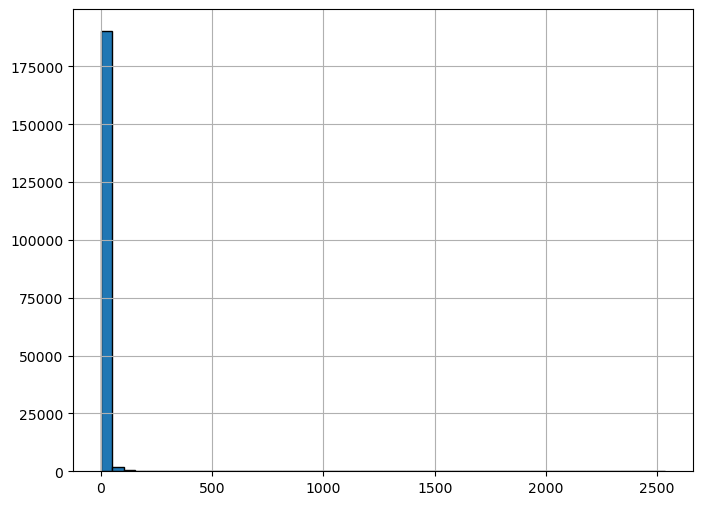

In [49]:
#### Majority of the products have received 1 rating only and it is a right skewed distribution
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['rating_counts'].hist(bins=50)

<Figure size 800x600 with 0 Axes>

<Axes: >

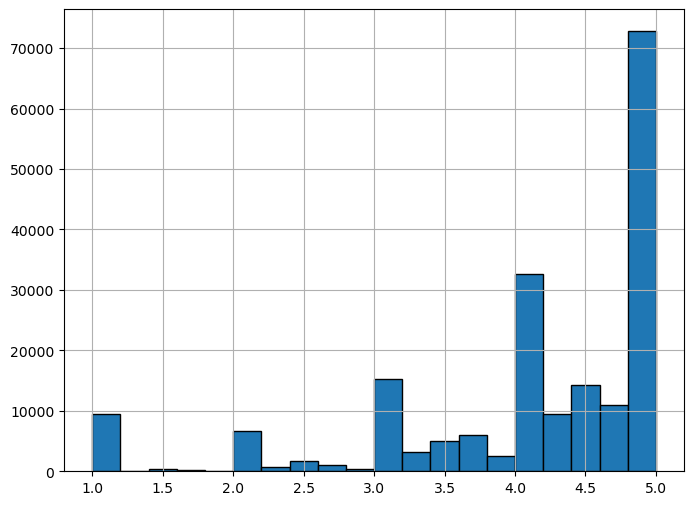

In [50]:
#We see a left skewed distribution for the ratings
#There are clusters at each of the points 1,2,3,4,5 as that is where the means are concentrated
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['ratings'].hist(bins=20)

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

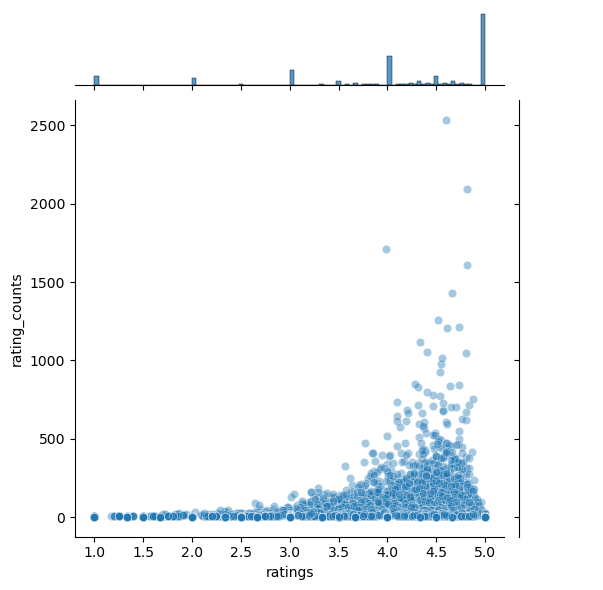

In [51]:
#From the joint plot below it seems that popular products (higher ratings) tend to be rated more frequently, majority have rated products in the higher range
#To make people more engaged (bottom of the chart) we can start by recommending them based on popularity based system and then
#slowly graduate them to collaborative system once we have sufficient number of data points to giver personlized recommendation
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
sns.jointplot(x='ratings', y='rating_counts', data=ratings_mean_count, alpha=0.4)

<Axes: xlabel='productId'>

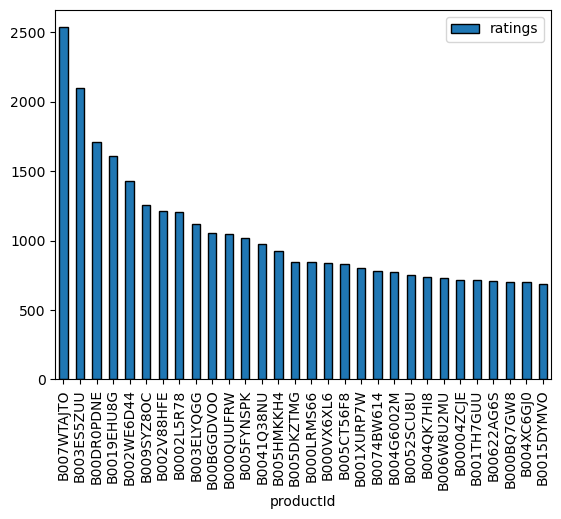

In [52]:
popular_products = pd.DataFrame(df1_final.groupby('productId')['ratings'].count())
most_popular = popular_products.sort_values('ratings', ascending=False)
most_popular.head(30).plot(kind = "bar")

In [53]:
no_of_ratings_per_user = df1_final.groupby(by='userId')['ratings'].count().sort_values(ascending=False)

In [54]:
no_of_ratings_per_user

userId
A5JLAU2ARJ0BO            520
ADLVFFE4VBT8             501
A3OXHLG6DIBRW8           498
A6FIAB28IS79             431
A680RUE1FDO8B            406
                        ... 
A3TSV62X5VE2NW            10
A20Q1PXCTPLHIP            10
A3TTT6Y7YSZJKT            10
A20PWU17CYC1HV            10
A00473363TJ8YSZ3YAGG9     10
Name: ratings, Length: 63175, dtype: int64

In [55]:
# Using popularity based recommender model to make predictions and find recommendations for random list of users with inferences

import warnings
warnings.filterwarnings('ignore')
def recommend(userId):     
    user_recommendations = popularity_recommendations 
          
    #Adding user_id column for which the recommendations are being generated 
    user_recommendations['userID'] = userId 
      
    #Bringing user_id column to the front 
    cols = user_recommendations.columns.tolist() 
    cols = cols[-1:] + cols[:-1] 
    user_recommendations = user_recommendations[cols] 
          
    return user_recommendations 

In [56]:
find_recom = [15,121,55,230,344]   # This list is user choice.
for i in find_recom:
    print("Here is the recommendation for the userId: %d\n" %(i))
    print(recommend(i))    
    print("\n") 

Here is the recommendation for the userId: 15

        userID   productId  score  Rank
308398      15  B0074BW614  18244   1.0
429572      15  B00DR0PDNE  16454   2.0
327308      15  B007WTAJTO  14172   3.0
102804      15  B0019EHU8G  12285   4.0
296625      15  B006GWO5WK  12226   5.0
178601      15  B003ELYQGG  11617   6.0
178813      15  B003ES5ZUU  10276   7.0
323013      15  B007R5YDYA   9907   8.0
289775      15  B00622AG6S   9823   9.0
30276       15  B0002L5R78   9487  10.0
350267      15  B008OHNZI0   8966  11.0
186026      15  B003LR7ME6   8840  12.0
67438       15  B000LRMS66   8715  13.0
372967      15  B009SYZ8OC   8370  14.0
401632      15  B00BGA9WK2   7561  15.0
239502      15  B004QK7HI8   7060  16.0
362459      15  B009A5204K   7059  17.0
401749      15  B00BGGDVOO   6893  18.0
361273      15  B0098F5W0Q   6616  19.0
147929      15  B002MAPRYU   6599  20.0
158901      15  B002WE6D44   6509  21.0
274153      15  B005HMKKH4   6134  22.0
92806       15  B0012S4APK   5642

In [57]:
trainset, testset = train_test_split(df, test_size=.30, random_state=7)

In [58]:
df.groupby('productId')['ratings'].mean().head()

productId
0132793040    5.000000
0321732944    5.000000
0439886341    1.666667
0511189877    4.500000
0528881469    2.851852
Name: ratings, dtype: float64

In [59]:
df.groupby('productId')['ratings'].mean().sort_values(ascending=False).head()


productId
0132793040    5.0
B004SGH244    5.0
B004SQBRRM    5.0
B004SQC6O0    5.0
B004SQE6YI    5.0
Name: ratings, dtype: float64

In [60]:
prod_rating_count = pd.DataFrame(df.groupby('productId')['ratings'].mean().sort_values(ascending=False))
prod_rating_count['prod_rating_count'] = pd.DataFrame(df.groupby('productId')['ratings'].count())
prod_rating_count.head(k)

,ratings,prod_rating_count
productId,,
0132793040,5.0,1
B004SGH244,5.0,1
B004SQBRRM,5.0,1
B004SQC6O0,5.0,1
B004SQE6YI,5.0,1
B004SQFFCK,5.0,1
B004SQOR0G,5.0,1
B004SQVHU4,5.0,1
B004SQX8W4,5.0,1


In [61]:
basic_poplurity_model = prod_rating_count.sort_values(by=['prod_rating_count'], ascending=False)
basic_poplurity_model.head(k)

,ratings,prod_rating_count
productId,,
B0074BW614,4.491504,18244
B00DR0PDNE,3.931020,16454
B007WTAJTO,4.424005,14172
B0019EHU8G,4.754497,12285
B006GWO5WK,4.314657,12226
B003ELYQGG,4.392528,11617
B003ES5ZUU,4.704749,10276
B007R5YDYA,4.690926,9907
B00622AG6S,4.420136,9823


In [62]:
#Count of user_id for each unique song as recommendation score 
panda_data_grouped = panda_data.groupby('productId').agg({'userId': 'count'}).reset_index()
panda_data_grouped.rename(columns = {'userId': 'score'},inplace=True)
panda_data_grouped.head()

,productId,score
0,B00001P4XA,12
1,B00001P4ZH,17
2,B00001WRSJ,16
3,B00001ZWXA,10
4,B00004SABB,13


In [69]:
#Sort the songs on recommendation score 
panda_data_sort = panda_data_grouped.sort_values(['score', 'productId'], ascending = [0,1]) 
      
#Generate a recommendation rank based upon score 
panda_data_sort['Rank'] = panda_data_sort['score'].rank(ascending=0, method='first') 
          
#Get the top 5 recommendations 
popularity_recommendations = panda_data_sort.head(k) 
popularity_recommendations 

,productId,score,Rank
1592,B0088CJT4U,206,1.0
839,B003ES5ZUU,184,2.0
226,B000N99BBC,167,3.0
1552,B007WTAJTO,164,4.0
1577,B00829TIEK,149,5.0
1573,B00829THK0,137,6.0
1613,B008DWCRQW,137,7.0
715,B002R5AM7C,128,8.0
1057,B004CLYEDC,118,9.0
728,B002SZEOLG,113,10.0


In [43]:
trainset, testset = train_test_split(df, test_size=.30, random_state=7)

In [44]:
df

,userId,productId,ratings
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0
...,...,...,...
7824477,A2YZI3C9MOHC0L,BT008UKTMW,5.0
7824478,A322MDK0M89RHN,BT008UKTMW,5.0
7824479,A1MH90R0ADMIK0,BT008UKTMW,4.0
7824480,A10M2KEFPEQDHN,BT008UKTMW,4.0


In [47]:
trainset

,userId,productId,ratings
7794834,A1S59XUS6TMYN4,B00INNAE20,1.0
4778207,A3GUQWA15H7YV7,B0058UUR6E,5.0
473036,AFUWKGBNWQCVQ,B0002IWC9C,5.0
7652697,A336TFY5839CW9,B00FQ9I822,4.0
2425944,APCR0G7F5M385,B0024R4B5C,5.0
...,...,...,...
3905091,A1FF5AF5DO1XGY,B00466X9SY,1.0
2632182,A1QGERWMLT1WLF,B002IKLJVE,5.0
2671129,A3M81KUGKRG4V4,B002KOERJE,4.0
3335364,A1VD7XL4M90O1F,B003FK81US,5.0


In [48]:
testset

,userId,productId,ratings
5965553,A3AKOQXP2KUM3K,B007XNL46G,4.0
2808803,A1VN3LXKW0L89Q,B002RM08RE,1.0
7244938,A3SK13ZB57KDER,B00CDIK48U,3.0
2545342,AJE705WGX0KZE,B002CZQ4GU,5.0
1484114,A3G1OJEVMLSY18,B000WHWQX0,5.0
...,...,...,...
5883592,AED8XQDUKPW5E,B007RE0EQC,3.0
6414375,A58QDOEJHQLQ7,B008YRG5JQ,4.0
1808034,A2C84OC4D0UPMP,B00192VWVY,4.0
2912212,A3KRR4Y9C6W0IF,B002WE4HE2,5.0


# 4. Splitting the data

In [76]:
#Split the data randomnly into train and test datasets into 70:30 ratio
df1_final = df1.copy()
train_data, test_data = train_test_split(df1_final, test_size = 0.3, random_state=0)
train_data.head()

,userId,productId,ratings
5258360,A1H898ODS23YBE,B0060I17XA,5.0
4191577,A3OATVQ0ZPA0O9,B004J3Y9U6,3.0
5574835,A10F3XNIDFZK08,B0073HSHVM,3.0
1619920,AOEAD7DPLZE53,B0012W7HQK,5.0
424298,A2T5K3LO6TQMQW,B00022OBOM,4.0


In [77]:
print('Shape of training data: ',train_data.shape)
print('Shape of testing data: ',test_data.shape)

Shape of training data:  (5477137, 3)
Shape of testing data:  (2347345, 3)


# 5. Building Popularity Based Recommender model

### Manual Popularity Based Model

In [51]:
#Count of user_id for each unique product as recommendation score 
train_data_grouped = df.groupby('productId').agg({'userId': 'count'}).reset_index()
train_data_grouped.rename(columns = {'userId': 'score'},inplace=True)
train_data_grouped.head(10)

,productId,score
0,0132793040,1
1,0321732944,1
2,0439886341,3
3,0511189877,6
4,0528881469,27
5,0558835155,1
6,059400232X,3
7,0594012015,8
8,0594017343,1
9,0594017580,1


In [79]:
#Sort the products on recommendation score 
train_data_sort = train_data_grouped.sort_values(['score', 'productId'], ascending = [0,1]) 
      
#Generate a recommendation rank based upon score 
train_data_sort['rank'] = train_data_sort['score'].rank(ascending=0, method='first') 
          
#Get the top 5 recommendations 
popularity_recommendations = train_data_sort.head(5) 
popularity_recommendations 

,productId,score,rank
271590,B0074BW614,12730,1.0
375363,B00DR0PDNE,11499,2.0
287933,B007WTAJTO,9994,3.0
261254,B006GWO5WK,8567,4.0
91788,B0019EHU8G,8547,5.0


In [80]:
# Sample fuction to use manual popularity based recommender model to make predictions
def recommend(user_id):     
    user_recommendations = popularity_recommendations 
          
    #Add user_id column for which the recommendations are being generated 
    user_recommendations['userId'] = user_id 
      
    #Bring user_id column to the front 
    cols = user_recommendations.columns.tolist() 
    cols = cols[-1:] + cols[:-1] 
    user_recommendations = user_recommendations[cols] 
          
    return user_recommendations 

In [81]:
# Since, it is a Popularity recommender model, so, all the three users are given the same recommendations. Here, we predict the products based on the popularity. It is not personalized to particular user. It is a non-personalized recommender system.
find_recom = [500,1000,1500]   # This list is user choice.
for i in find_recom:
    print("The list of recommendations for the userId: %d\n" %(i))
    print(recommend(i))    
    print("\n") 

The list of recommendations for the userId: 500

        userId   productId  score  rank
271590     500  B0074BW614  12730   1.0
375363     500  B00DR0PDNE  11499   2.0
287933     500  B007WTAJTO   9994   3.0
261254     500  B006GWO5WK   8567   4.0
91788      500  B0019EHU8G   8547   5.0


The list of recommendations for the userId: 1000

        userId   productId  score  rank
271590    1000  B0074BW614  12730   1.0
375363    1000  B00DR0PDNE  11499   2.0
287933    1000  B007WTAJTO   9994   3.0
261254    1000  B006GWO5WK   8567   4.0
91788     1000  B0019EHU8G   8547   5.0


The list of recommendations for the userId: 1500

        userId   productId  score  rank
271590    1500  B0074BW614  12730   1.0
375363    1500  B00DR0PDNE  11499   2.0
287933    1500  B007WTAJTO   9994   3.0
261254    1500  B006GWO5WK   8567   4.0
91788     1500  B0019EHU8G   8547   5.0




#### Evaluation of the manual popularity based model

In [82]:
#Calculating the RMSE of the popularity based recommendation system
#Rating present in the test data is the actual rating (Act_rating)
test_data2 = test_data.copy()
#ratings.drop(['timestamp'], axis=1,inplace=True)
test_data2.drop(['userId'],axis=1,inplace=True)
test_data2.rename(columns = {'ratings':'Act_rating'}, inplace = True)

In [83]:
#Count of user_id for each unique product as recommendation score 
train_data_grouped2 = train_data.groupby('productId').agg({'ratings': 'sum'}).reset_index()
train_data_grouped2.rename(columns = {'ratings': 'Sum_rating'},inplace=True)
train_data_grouped2.head()


,productId,Sum_rating
0,0439886341,5.0
1,0511189877,20.0
2,0528881469,58.0
3,0558835155,3.0
4,059400232X,15.0


In [84]:
train_data_inner = pd.merge(train_data_grouped2, train_data_sort)
train_data_inner.head()

,productId,Sum_rating,score,rank
0,0439886341,5.0,3,149370.0
1,0511189877,20.0,4,127347.0
2,0528881469,58.0,20,41651.0
3,0558835155,3.0,1,247879.0
4,059400232X,15.0,3,149371.0


In [85]:
#Obtain the average rating of the product across users
train_data_inner["Avg_Rating"] = train_data_inner["Sum_rating"]/train_data_inner["score"]
train_data_inner.head()

,productId,Sum_rating,score,rank,Avg_Rating
0,0439886341,5.0,3,149370.0,1.666667
1,0511189877,20.0,4,127347.0,5.000000
2,0528881469,58.0,20,41651.0,2.900000
3,0558835155,3.0,1,247879.0,3.000000
4,059400232X,15.0,3,149371.0,5.000000


In [86]:
#Merge the train data having average rating with the test data having actual rating at product level
test_data_inner = pd.merge(train_data_inner, test_data2)
test_data_inner.head()

,productId,Sum_rating,score,rank,Avg_Rating,Act_rating
0,0511189877,20.0,4,127347.0,5.0,5.0
1,0511189877,20.0,4,127347.0,5.0,2.0
2,0528881469,58.0,20,41651.0,2.9,4.0
3,0528881469,58.0,20,41651.0,2.9,5.0
4,0528881469,58.0,20,41651.0,2.9,4.0


In [87]:
#RMSE for popularity based recommender system is 1.09
mse = mean_squared_error(test_data_inner["Act_rating"], test_data_inner["Avg_Rating"])
rmse = math.sqrt(mse)
print("RMSE for popularity based recommendation system:", rmse)

RMSE for popularity based recommendation system: 1.3222726958419337


## Popularity recommender

In [ ]:
Take a subset of the dataset to make it less sparse/ denser. ( For example, keep the users only who has given 50 or more number of ratings )
userID = recomm_df.groupby('userID').count()
top_user = userID[userID['ratings'] >= 50].index
topuser_ratings_df = recomm_df[recomm_df['userID'].isin(top_user)]
#topuser_ratings_df.drop('productID', axis=1, inplace = True)
topuser_ratings_df.shape

topuser_ratings_df.sort_values(by='ratings', ascending=False).head()

# Keep data only for products that have 50 or more ratings
prodID = recomm_df.groupby('productID').count()
top_prod = prodID[prodID['ratings'] >= 50].index
top_ratings_df = topuser_ratings_df[topuser_ratings_df['productID'].isin(top_prod)]
top_ratings_df.sort_values(by='ratings', ascending=False).head()

top_ratings_df.shape

# Split the data randomly into train and test dataset. ( For example, split it in 70/30 ratio)
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(top_ratings_df, test_size = 0.30, random_state=0)
train_data.head()

test_data.head()


#Building the recommendations based on the average of all user ratings for each product.
train_data_grouped = train_data.groupby('productID').mean().reset_index()
train_data_grouped.head()

train_data_sort = train_data_grouped.sort_values(['ratings', 'productID'], ascending=False)
train_data_sort.head()

train_data.groupby('productID')['ratings'].count().sort_values(ascending=False).head(10) 

ratings_mean_count = pd.DataFrame(train_data.groupby('productID')['ratings'].mean()) 
ratings_mean_count['rating_counts'] = pd.DataFrame(train_data.groupby('productID')['ratings'].count())  
ratings_mean_count.head()  
ratings	rating_counts

pred_df = test_data[['userID', 'productID', 'ratings']]
pred_df.rename(columns = {'ratings' : 'true_ratings'}, inplace=True)
pred_df = pred_df.merge(train_data_sort, left_on='productID', right_on = 'productID')
pred_df.head(3)

pred_df.rename(columns = {'ratings' : 'predicted_ratings'}, inplace = True)
pred_df.head()

import sklearn.metrics as metric
from math import sqrt
MSE = metric.mean_squared_error(pred_df['true_ratings'], pred_df['predicted_ratings'])
print('The RMSE value for Popularity Recommender model is', sqrt(MSE))

In [7]:
df1 = df.copy()

## Using additional collaboartive models


#### Merging the datasets to get data where each product has atleast 25 ratings and each user has given atleast 25 ratings
#### This makes the matrix more dense and also allows GridSearch algo to run, else it is failing
#### Taking a 10% random sample with full data as the SVD decomposition is failing

#### * Use K nearest neighbour (basic, with means, and normalized (z-score))
#### * Support Vector Decomposition (SVD)
#### * Co-clustering

In [8]:
rts_gp = df1.groupby(by=['ratings']).agg({'userId': 'count'}).reset_index()
rts_gp.columns = ['ratings', 'Count']

#Subsetting the data to keep products having at least 25 ratings
prod_ge_25=df1.groupby("productId").filter(lambda x:x['ratings'].count() >= 25)

#Subsetting the data to keep users who have given at least 25 ratings
user_ge_25=df.groupby("userId").filter(lambda x:x['ratings'].count() >= 25)
user_ge_25.drop(['ratings'],inplace=True,axis=1)
user_prod_ge_25 = pd.merge(prod_ge_25,user_ge_25)
user_prod_ge_25.shape

(255557, 4)

In [52]:
#Taking a 10% random sample with full data as the SVD decomposition is failing
new_df2 = user_prod_ge_25.sample(frac=0.25, replace=False, random_state=0)

In [53]:
# Set Rating Scale from 1 to 5
#We are running basic algorithms to check which one works best
reader = Reader(rating_scale=(1, 5))

# Load data with rating scale
#data = Dataset.load_from_df(new_df, reader)
data = Dataset.load_from_df(new_df2,reader)

In [ ]:
knnbasic_cv = cross_validate(KNNBasic(), data, cv=5, n_jobs=5, verbose=True)

In [9]:
knnmeans_cv = cross_validate(KNNWithMeans(), data, cv=5, n_jobs=5, verbose=True)

NameError: name 'data' is not defined

In [ ]:
coclus_cv = cross_validate(CoClustering(), data, cv=5, n_jobs=5, verbose=True)

In [ ]:
knnz_cv = cross_validate(KNNWithZScore(), data, cv=5, n_jobs=5, verbose=True)

In [ ]:
nmf_cv = cross_validate(NMF(), data, cv=5, n_jobs=5, verbose=True)

In [ ]:
svdpp_cv = cross_validate(SVDpp(), data, cv=5, n_jobs=5, verbose=True)

In [ ]:
svd_cv = cross_validate(SVD(), data, cv=5, n_jobs=5, verbose=True)

In [ ]:
slope_cv = cross_validate(SlopeOne(), data, cv=5, n_jobs=5, verbose=True)

In [ ]:
print('Algorithm\t RMSE\t\t MAE')
print()
print('KNN Basic', '\t', round(knnbasic_cv['test_rmse'].mean(), 4), '\t', round(knnbasic_cv['test_mae'].mean(), 4))
print('KNN Means', '\t', round(knnmeans_cv['test_rmse'].mean(), 4), '\t', round(knnmeans_cv['test_mae'].mean(), 4))
print('KNN ZScore', '\t', round(knnz_cv['test_rmse'].mean(), 4), '\t', round(knnz_cv['test_mae'].mean(), 4))
print()
print('SVD', '\t\t', round(svd_cv['test_rmse'].mean(), 4), '\t', round(svd_cv['test_mae'].mean(), 4))
print('SVDpp', '\t\t', round(svdpp_cv['test_rmse'].mean(), 4), '\t', round(svdpp_cv['test_mae'].mean(), 4))
print('NMF', '\t\t', round(nmf_cv['test_rmse'].mean(), 4), '\t', round(nmf_cv['test_mae'].mean(), 4))
print()
print('SlopeOne', '\t', round(slope_cv['test_rmse'].mean(), 4), '\t', round(slope_cv['test_mae'].mean(), 4))
print('CoClustering', '\t', round(coclus_cv['test_rmse'].mean(), 4), '\t', round(coclus_cv['test_mae'].mean(), 4))
print()

<Figure size 1440x360 with 0 Axes>

<AxesSubplot:>

Text(0.5, 1.0, 'Comparison of Algorithms on RMSE')

Text(0.5, 0, 'Algorithms')

Text(0, 0.5, 'RMSE Value')

<AxesSubplot:>

Text(0.5, 1.0, 'Comparison of Algorithms on MAE')

Text(0.5, 0, 'Algorithms')

Text(0, 0.5, 'MAE Value')

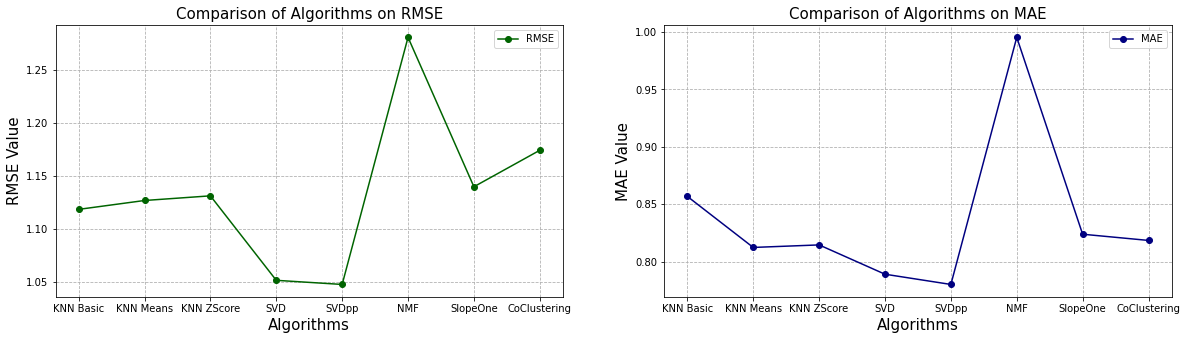

In [ ]:
x_algo = ['KNN Basic', 'KNN Means', 'KNN ZScore', 'SVD', 'SVDpp', 'NMF', 'SlopeOne', 'CoClustering']
all_algos_cv = [knnbasic_cv, knnmeans_cv, knnz_cv, svd_cv, svdpp_cv, nmf_cv, slope_cv, coclus_cv]

rmse_cv = [round(res['test_rmse'].mean(), 4) for res in all_algos_cv]
mae_cv = [round(res['test_mae'].mean(), 4) for res in all_algos_cv]

plt.figure(figsize=(20,5))

plt.subplot(1, 2, 1)
plt.title('Comparison of Algorithms on RMSE', loc='center', fontsize=15)
plt.plot(x_algo, rmse_cv, label='RMSE', color='darkgreen', marker='o')
plt.xlabel('Algorithms', fontsize=15)
plt.ylabel('RMSE Value', fontsize=15)
plt.legend()
plt.grid(ls='dashed')

plt.subplot(1, 2, 2)
plt.title('Comparison of Algorithms on MAE', loc='center', fontsize=15)
plt.plot(x_algo, mae_cv, label='MAE', color='navy', marker='o')
plt.xlabel('Algorithms', fontsize=15)
plt.ylabel('MAE Value', fontsize=15)
plt.legend()
plt.grid(ls='dashed')

plt.show()

# 7. Hyperparameter Tuning:  Grid Searching on SVD and SVDPP algorithms


In [ ]:
# Split the data into 70% / 30%
# trainset, testset = train_test_split(data, test_size=.30)
# trainset = dataset_svd.build_full_trainset()
# testset = trainset.build_anti_testset()
raw_ratings = data.raw_ratings                         # 90% trainset, 10% testset                                                
threshold = int(.9 * len(raw_ratings))                                     
trainset_raw_ratings = raw_ratings[:threshold]                             
test_raw_ratings = raw_ratings[threshold:]             
data.raw_ratings = trainset_raw_ratings        


In [ ]:
from surprise import accuracy                                              

data = df.copy()
# Parameter space
svd_param_grid = {'n_epochs': [20, 25], 
                  'lr_all': [0.007, 0.009, 0.01],
                  'reg_all': [0.4, 0.6]}

svdpp_gs = GridSearchCV(SVDpp, svd_param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=5)
svdpp_gs.fit(data)
algo_svdpp = svdpp_gs.best_estimator['rmse']    
# retrain on the whole train set                      
# 
trainset = data.build_full_trainset()                 
algo_svdpp.fit(trainset)
# now test on the trainset                                                 
testset = data.construct_testset(trainset_raw_ratings)                     
predictions_train = algo_svdpp.test(testset)                                           
print('Accuracy on the trainset:')                                         
accuracy.rmse(predictions_train)                                                 

# now test on the testset                                                  
testset = data.construct_testset(test_raw_ratings)                         
pred_svdpp=algo_svdpp.test(testset)
print('Accuracy on the testset:')                                          
accuracy.rmse(pred_svdpp)  


svd_gs = GridSearchCV(SVD, svd_param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=5)
svd_gs.fit(data)
algo_svd = svd_gs.best_estimator['rmse']    
# retrain on the whole train set                      
trainset = data.build_full_trainset()                  
algo_svd.fit(trainset)
# now test on the trainset                                                 
testset = data.construct_testset(trainset_raw_ratings)                     
predictions_train = algo_svd.test(testset)                                           
print('Accuracy on the trainset:')                                         
accuracy.rmse(predictions_train)                                                 

# now test on the testset                                                  
testset = data.construct_testset(test_raw_ratings)                         
pred_svd=algo_svd.test(testset)
print('Accuracy on the testset:')                                          
accuracy.rmse(pred_svd)  




Accuracy on the trainset:
RMSE: 0.8331


0.8331049844232481

Accuracy on the testset:
RMSE: 1.0405


1.0404897845858163

Accuracy on the trainset:
RMSE: 0.7766


0.7766243501964588

Accuracy on the testset:
RMSE: 1.0409


1.0409316936319148

user: 150        item: 10000      r_ui = 4.00   est = 4.27   {'was_impossible': False}


In [ ]:
print('SVDpp - RMSE:', round(svdpp_gs.best_score['rmse'], 4), '; MAE:', round(svdpp_gs.best_score['mae'], 4))
print('SVD   - RMSE:', round(svd_gs.best_score['rmse'], 4), '; MAE:', round(svd_gs.best_score['mae'], 4))
print('RMSE =', svdpp_gs.best_params['rmse'])
print('MAE =', svdpp_gs.best_params['mae'])
print('RMSE =', svd_gs.best_params['rmse'])
print('MAE =', svd_gs.best_params['mae'])

SVDpp - RMSE: 1.0469 ; MAE: 0.7819
SVD   - RMSE: 1.047 ; MAE: 0.7831
RMSE = {'n_epochs': 20, 'lr_all': 0.009, 'reg_all': 0.6}
MAE = {'n_epochs': 25, 'lr_all': 0.01, 'reg_all': 0.4}
RMSE = {'n_epochs': 20, 'lr_all': 0.009, 'reg_all': 0.6}
MAE = {'n_epochs': 25, 'lr_all': 0.01, 'reg_all': 0.4}


In [ ]:
from collections import defaultdict
def get_top_n_recommendations(reccomemndations, n=5):
    # First map the reccommendations to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in reccomemndations:
        top_n[uid].append((iid, est))

    #sort predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [ ]:
top_5 = get_top_n_recommendations(pred_svd, n=5)
for uid, user_ratings in top_5.items():
    print(uid, [iid for (iid, _) in user_ratings])


A249FZIEJXNWR ['B007YCA6UG']
A1OCDMMZ8B5BIE ['B0014IUWU0']
AMP7TQRWAIE84 ['B000H6AY6M']
A379LXOWA6ZXGD ['B005VP9MO4']
A3DFGT63ADLNI0 ['B00126U0VA']
A28PQWS9Z01FG3 ['B006C2GNDS']
AH3LF9RAD1O2V ['B001KZ6C74']
A2HM0AZ8WQFWU7 ['B0006BGV2Y', 'B000XY4AD6', 'B000VHQA6U']
AP8EXADSLHZET ['B003B48UQ8']
A183V4P6U4CFBF ['B003F5NS9W']
A24W1A0CW6CW5R ['B002MAPSDA', 'B005F77Z9C']
A3RTCA21S7BQ3P ['B00HFFDDLG', 'B006T9FURY']
A3M2TMPK88UCSR ['B001L2WCE8']
AODZQ5RTAM3EY ['B0041UJVI2']
A3F5NFPJ5XTT2Q ['B00361EZX8']
A2SBFXPN5V6A6X ['B0049YQVHE']
A2WO3RGJHZIKHX ['B005FYNSPK']
AVJ6URCLNJQD2 ['B008ABOJKS']
A50W36ATFDSNU ['B007V9SNNY']
A3KZ7OH4VRL048 ['B000RK89M4']
A2H44WVZS59KKT ['B0085RZPPA']
A5X6PJANY4XW4 ['B00005114Z']
A39L35PUI58CFY ['B0012S4APK']
A2TFRNUZOE5OLQ ['B0079MVJ4I']
A10CRW7XRJBJ2G ['B000BQ7GW8', 'B007OOURHQ']
A4GGT6O0GQNV2 ['B00HRO3IBA']
AMBFK6N4JS5Z2 ['B004TPJKEY', 'B005K69PLE']
A1KY25HG3D9NWB ['B00A3YDKRI']
A2QAN27NWI581E ['B002MA6FYG']
ATWTKK5MU6RCI ['B00126R3P6']
A289ARF9YKYKD4 ['B0057CVH6